In [1]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as ms
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,precision_score, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

### 1. Accessing the data and cleaning it up.

In [2]:
ds = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
pd.set_option("display.max_columns",None)

In [4]:
ds.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# checking the non-numeric value in TotalCharges column as it shows datatype = object
#ds["TotalCharges"] = ds["TotalCharges"].astype(float)

In [7]:
ds["TotalCharges"] = ds["TotalCharges"].replace({" ":"0"})

In [8]:
ds["TotalCharges"] = ds["TotalCharges"].astype(float)

In [9]:
# Removing the ID column
ds = ds.drop(columns=["customerID"])

In [10]:
ds.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [11]:
# printing the unique values of the columns
numeric_column = ["tenure","MonthlyCharges","TotalCharges"]
for col in ds.columns:
  if col not in numeric_column:
    print(f"{col} : {ds[col].unique()}")
    print("-"*50)

gender : ['Female' 'Male']
--------------------------------------------------
SeniorCitizen : [0 1]
--------------------------------------------------
Partner : ['Yes' 'No']
--------------------------------------------------
Dependents : ['No' 'Yes']
--------------------------------------------------
PhoneService : ['No' 'Yes']
--------------------------------------------------
MultipleLines : ['No phone service' 'No' 'Yes']
--------------------------------------------------
InternetService : ['DSL' 'Fiber optic' 'No']
--------------------------------------------------
OnlineSecurity : ['No' 'Yes' 'No internet service']
--------------------------------------------------
OnlineBackup : ['Yes' 'No' 'No internet service']
--------------------------------------------------
DeviceProtection : ['No' 'Yes' 'No internet service']
--------------------------------------------------
TechSupport : ['No' 'Yes' 'No internet service']
--------------------------------------------------
StreamingTV : [

In [12]:
# Taking only object columns
obj_cols = ds.select_dtypes("object").columns.to_list()

In [13]:
obj_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [14]:
# endcoding the columns
encoder = {}

for col in obj_cols:
  le = LabelEncoder()
  ds[col] = le.fit_transform(ds[col])
  encoder[col] = le

# save as model
with open("encoder.pkl","wb") as f:
  pickle.dump(encoder,f)

In [15]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   int64  
 7   InternetService   7043 non-null   int64  
 8   OnlineSecurity    7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  DeviceProtection  7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
 12  StreamingTV       7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  Contract          7043 non-null   int64  
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null   int64  


checking the relationship of the customer data and the churn

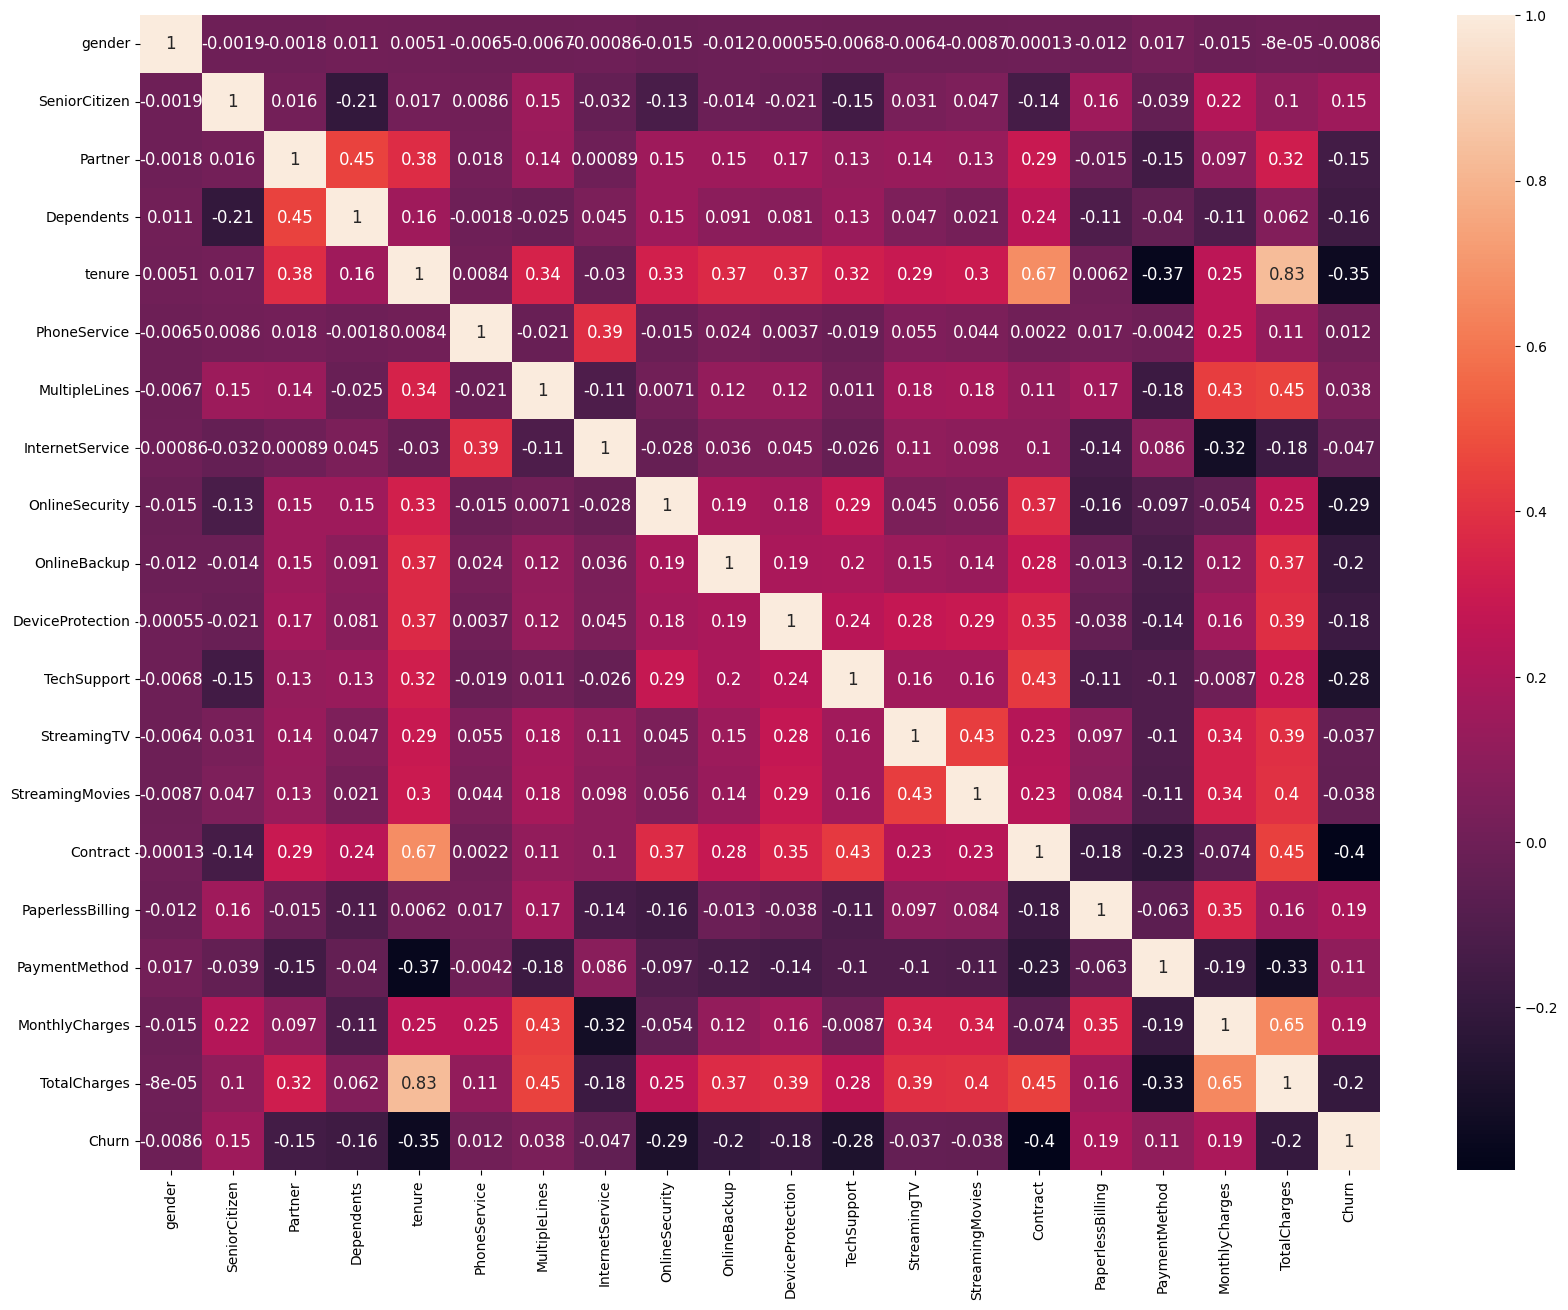

In [16]:
corr = ds.corr()
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values,annot=True,annot_kws={"size":12})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [17]:
ds.shape

(7043, 20)

In [18]:
ds.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.504756,0.162147,0.483033,0.299588,32.371149,0.903166,0.940508,0.872923,0.790004,0.906432,0.904444,0.797104,0.985376,0.992475,0.690473,0.592219,1.574329,64.761692,2279.734304,0.265370
std,0.500013,0.368612,0.499748,0.458110,24.559481,0.295752,0.948554,0.737796,0.859848,0.880162,0.879949,0.861551,0.885002,0.885091,0.833755,0.491457,1.068104,30.090047,2266.794470,0.441561
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,35.500000,398.550000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,70.350000,1394.550000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,89.850000,3786.600000,1.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,118.750000,8684.800000,1.000000


Checking for outliers.

In [19]:
def outliers(df,col_name):
  plt.figure(figsize=(5,3))
  sns.boxplot(y=df[col_name])
  plt.title(f"Box plot of {col_name}")
  plt.ylabel(col_name)
  plt.show()

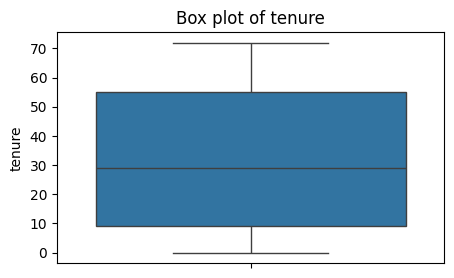

In [20]:
outliers(ds,"tenure")

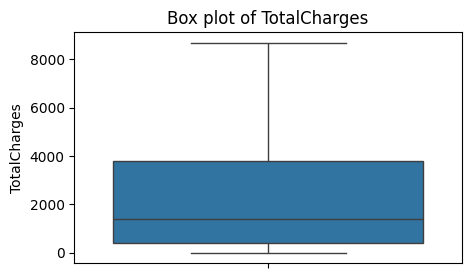

In [21]:
outliers(ds,"TotalCharges")

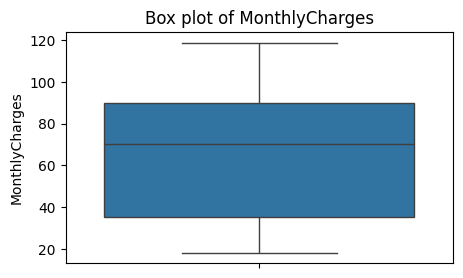

In [22]:
outliers(ds,"MonthlyCharges")

### 2. Exploring the Data

In [23]:
# Exploring how many customers in this dataset has churned
ds["Churn"].value_counts()
#We see this dataset actually has less than the overall 50% churn rate of the entire company reported data (it's actually 26.54% that have churned.

,count
Churn,
0,5174
1,1869


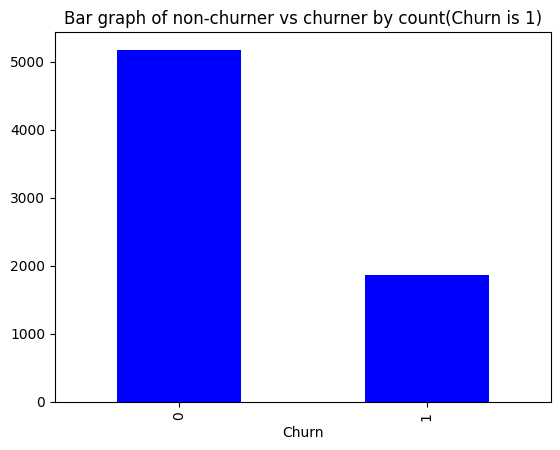

In [24]:
from ctypes import alignment
ds["Churn"].value_counts().plot(kind="bar",title="Bar graph of non-churner vs churner by count(Churn is 1)",color="blue",align="center")
plt.show()
# The dataset does not have a huge imbalance

In [25]:
ds.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


**Exploring some contengencies on how some features relate with churn**

In [26]:
# Creates initial contingency table between Churn and gender. Male is 0, Female is 1.
gender_churn_contengencies = pd.crosstab(ds["Churn"],ds["gender"])
display(gender_churn_contengencies)
# Male and Female are about the same rate. Not much to see here

gender,0,1
Churn,,
0,2549,2625
1,939,930


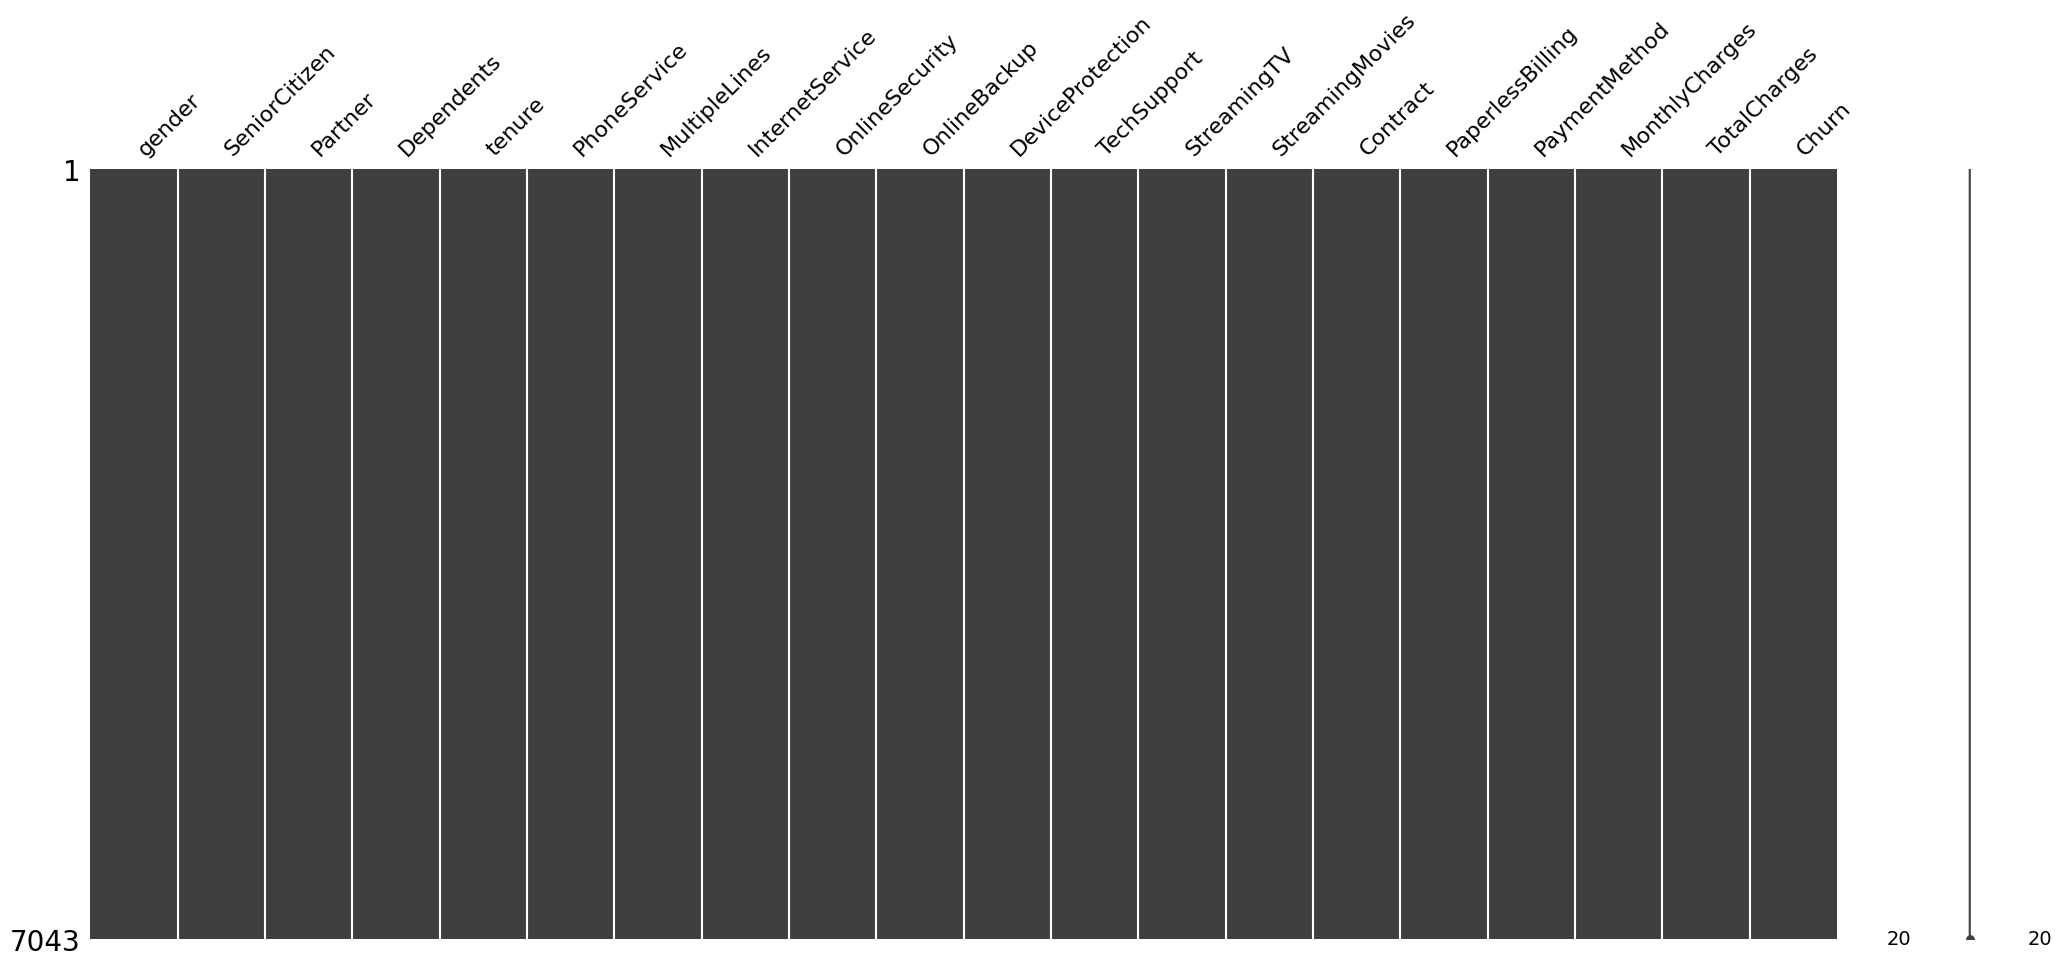

In [27]:
# Checking the data Health, it should be completely black which indicates that the data is complete
ms.matrix(ds)
plt.show()

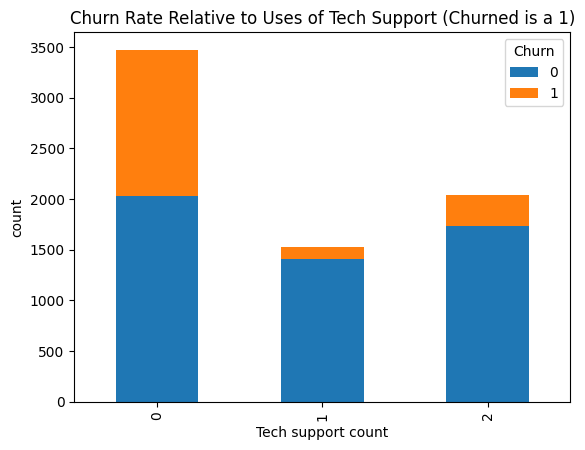

In [28]:
# Exploring how churn relate with the TechSupport
tech_support_churn_contengencies = pd.crosstab(ds["TechSupport"],ds["Churn"])
tech_support_churn_contengencies.plot(kind="bar",stacked=True)
plt.ylabel("count")
plt.xlabel("Tech support count")
plt.title("Churn Rate Relative to Uses of Tech Support (Churned is a 1)")
plt.show()
# We can see that non-churners use tech support more often than customers that end up churning.

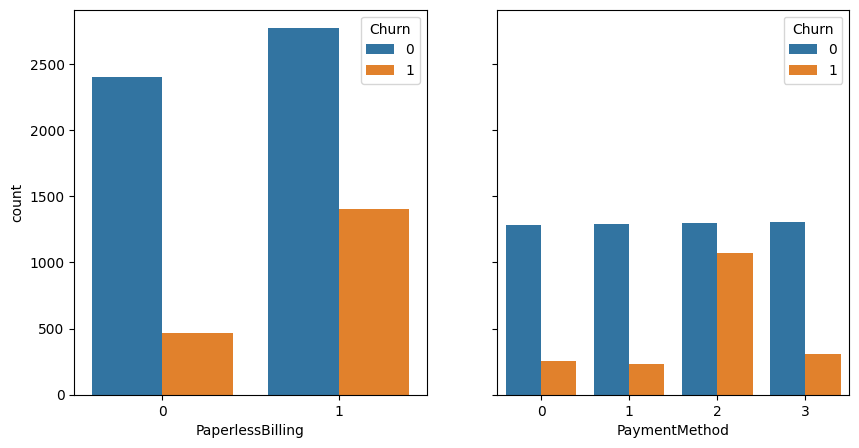

In [29]:
# Does how a customer pays have to do with their churn?
fig , ax = plt.subplots(1,2, sharey=True ,figsize=(10,5))
sns.countplot(x="PaperlessBilling",hue="Churn",data=ds,ax=ax[0])
sns.countplot(x="PaymentMethod",hue="Churn",data=ds,ax=ax[1])
plt.show()
# We can see that customers that use paperless billing are much more likely to churn (0 = don't have paperless billing).

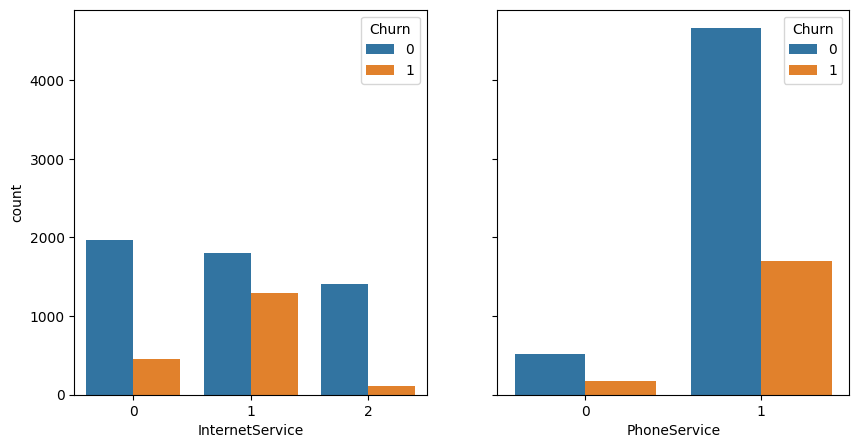

In [30]:
# Does the other product they have has do to with Churn?
fig , ax = plt.subplots(1,2, sharey=True ,figsize=(10,5))
sns.countplot(x="InternetService",hue="Churn",data=ds,ax=ax[0])
sns.countplot(x="PhoneService",hue="Churn",data=ds,ax=ax[1])
plt.show()
# We can see that if they don't have Phone Service, they are more likely to churn.
# Also if they don't have Internet Service, they are more likely to churn. Those customers with the highest Internet Service are least likely to churn.
# Conclusion: This makes sense. Customers with other products from the company, and premium products, churn less.

/tmp/ipython-input-3857563168.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ds["tenure"])


<Axes: xlabel='tenure', ylabel='Density'>

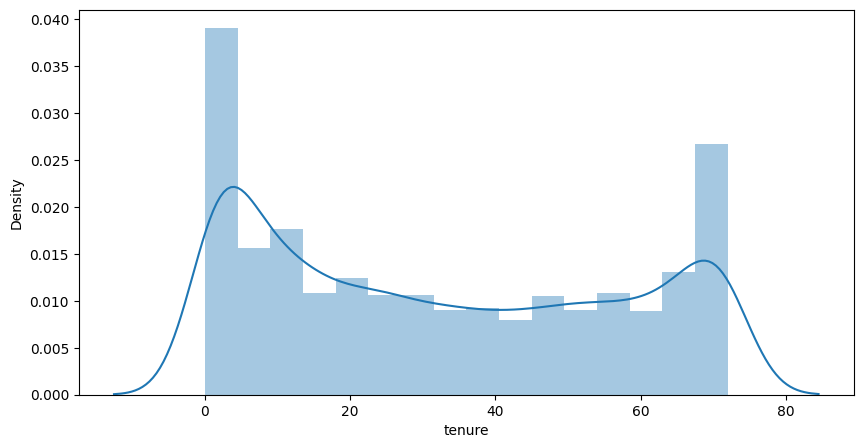

In [31]:
# plotting the distribution of Tenure
plt.figure(figsize=(10,5))
sns.distplot(ds["tenure"])
# It shows the max tenure is 70. This must be when the data history ends. We'll account for this in our analysis.

### 3. Splitting the Data



In [32]:
x = ds.drop(columns=["Churn"])
y = ds["Churn"]

In [33]:
x.shape

(7043, 19)

In [34]:
y.shape

(7043,)

In [35]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [36]:
x_train.shape

(5634, 19)

In [37]:
y_train.value_counts()

,count
Churn,
0,4138
1,1496


**using the Synthetic Minority Oversmapling Technique**

In [38]:
smote = SMOTE(random_state=42)
x_train_smote , y_train_smote = smote.fit_resample(x_train,y_train)

In [39]:
y_train_smote.value_counts()

,count
Churn,
0,4138
1,4138


**Model Trianing**

Training the model with default parameters

In [40]:
# Creating the dictionary of models
models = {
    "Decision Tree" : DecisionTreeClassifier(random_state=42),
    "Random Forest" : RandomForestClassifier(random_state=42),
    "XGBoost" : XGBClassifier(random_state=42)
}

In [41]:
# dictionary to store cross validation score
cv_score = {}

# Performing the 5-fold cross validation on each model
for model_name, model in models.items():
  print(f"Training {model_name} with default parameter")
  score = cross_val_score(model,x_train_smote,y_train_smote,cv=5,scoring="accuracy")
  cv_score[model_name] = score
  print(f"{model_name} cross validation accuracy: {np.mean(score):.2f}")
  print("-"*70)

Training Decision Tree with default parameter
Decision Tree cross validation accuracy: 0.78
----------------------------------------------------------------------
Training Random Forest with default parameter
Random Forest cross validation accuracy: 0.84
----------------------------------------------------------------------
Training XGBoost with default parameter
XGBoost cross validation accuracy: 0.83
----------------------------------------------------------------------


In [42]:
cv_score

{'Decision Tree': array([0.68297101, 0.71299094, 0.82175227, 0.83564955, 0.83564955]),
 'Random Forest': array([0.72524155, 0.77824773, 0.90513595, 0.89425982, 0.90090634]),
 'XGBoost': array([0.70048309, 0.75649547, 0.90271903, 0.89486405, 0.90030211])}

Random forest gives the high accuracy

In [43]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(x_train_smote,y_train_smote)

RandomForestClassifier(random_state=42)

In [44]:
print(y_test.value_counts())

Churn
0    1036
1     373
Name: count, dtype: int64


Model Evaluation

In [45]:
pred = rfc.predict(x_test)

In [46]:
print("Accuracy score: \n",accuracy_score(y_test,pred))
print("Confusion matrix: \n",confusion_matrix(y_test,pred))
print("classification report: \n",classification_report(y_test,pred))

Accuracy score: 
 0.7785663591199432
Confusion matrix: 
 [[878 158]
 [154 219]]
classification report: 
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      1036
           1       0.58      0.59      0.58       373

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



**Save the model and use it for making predictive system**

In [47]:
model_data = {"model": rfc , "features": x.columns.tolist()}

with open("churn_prediction_model.pkl","wb") as f:
  pickle.dump(model_data,f)

In [48]:
## Load the model
with open("churn_prediction_model.pkl","rb") as f:
  model_data = pickle.load(f)

model = model_data["model"]
features = model_data["features"]

In [49]:
print(model)

RandomForestClassifier(random_state=42)


In [50]:
print(features)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']


In [51]:
input_data = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 1,
    'PhoneService': 'No',
    'MultipleLines': 'No phone service',
    'InternetService': 'DSL',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 29.85,
    'TotalCharges': 29.85
}


input_data_df = pd.DataFrame([input_data])

with open("encoder.pkl", "rb") as f:
  encoders = pickle.load(f)


# encode categorical features using the saved encoders
for column in features: # Iterate over the features used by the model
  if column in encoders: # Only apply encoder if it's a categorical column that was encoded
    input_data_df[column] = encoders[column].transform(input_data_df[column])

# make a prediction
prediction = model.predict(input_data_df)
pred_prob = model.predict_proba(input_data_df)

print(prediction)

# results
print(f"Prediction: {'Churn' if prediction[0] == 1 else 'No Churn'}")
print(f"Prediciton Probability: {pred_prob}")

[0]
Prediction: No Churn
Prediciton Probability: [[0.78 0.22]]
